In [1]:
import pandas as pd

In [2]:
import pickle

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [5]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment-01")

<Experiment: artifact_location='/home/mikygetyos/Documents/My_Projects/NYC-Taxi-Duration/notebooks-exp-tracking/mlruns/1', creation_time=1685563639467, experiment_id='1', last_update_time=1685563639467, lifecycle_stage='active', name='nyc-taxi-experiment-01', tags={}>

In [6]:
def read_dataframe(filename):
    df = pd.read_parquet(filename)

    df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
    df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda trip_dur_min: trip_dur_min.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)

    return df

In [7]:
df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2021-02.parquet')

In [8]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [9]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

In [10]:
# Dictionary Vectorization, Training, Prediction and Evaluation

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [11]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [12]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)
mean_squared_error(y_val, y_pred, squared=False)

7.758715207983167

In [13]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

/tmp/ipykernel_111815/3467513732.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='Prediction')
/tmp/ipykernel_111815/3467513732.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='Actual')


<Axes: ylabel='Density'>

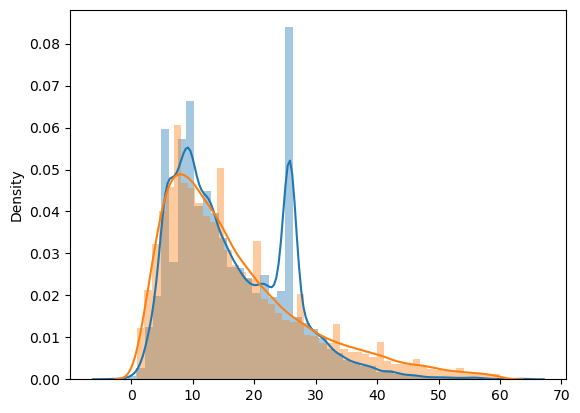

In [14]:
sns.distplot(y_pred, label='Prediction')
sns.distplot(y_train, label='Actual')

In [15]:
with open('models/lin_reg_2.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [16]:
with mlflow.start_run():

    mlflow.set_tag("Model", "Lasso")

    # First Lasso with default parameters
    lr = Lasso()
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)
    
    with open("models/lasso_regressor.bin", "wb") as f_out:
        pickle.dump(lr, f_out)

    mlflow.log_artifact(local_path="models/lasso_regressor.bin", artifact_path="Lasso-Model")

In [17]:
with mlflow.start_run():

    mlflow.set_tag("Developer", "Michael Getachew Abebe")

    mlflow.log_param("train-data-path", "./data/green_tripdata_2021-01.parquet")
    mlflow.log_param("validation-data-path", "./data/green_tripdata_2021-02.parquet")

    alpha = 0.1
    # Let's try with alpha = 0.001
    lr = Lasso(alpha)

    mlflow.log_param("alpha", alpha)

    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse = mean_squared_error(y_val, y_pred, squared = False)

    mlflow.log_metric("Root Mean Squared Error", rmse)

In [18]:
# Let's try with alpha = 0.01
lr = Lasso(alpha=0.01)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)
mean_squared_error(y_val, y_pred, squared=False)

11.167275941179728

In [19]:
#Let's try with alpha = 0.1
lr = Lasso(alpha=0.1)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)
mean_squared_error(y_val, y_pred, squared=False)

12.143233939663894

In [20]:
with mlflow.start_run():

    mlflow.set_tag("Models", "Ridge Regressor")

    # Let's try Ridge
    lr = Ridge()
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)

    with open("models/ridge_regressor.bin", "wb") as f_out:
        pickle.dump(lr, f_out)
    
    mlflow.log_artifact(local_path="models/ridge_regressor.bin", artifact_path="Ridge-Model")


In [21]:
# Hyperparameter Tunning using XGboost

import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [22]:
def objective(params):

    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost-model")
        mlflow.log_params(params)

        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, "validation")],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("Root Mean Squared Error", rmse)

    return {'loss':rmse, 'status': STATUS_OK}

In [34]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [24]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100,1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

[18:04:26] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:18.98297                          
[1]	validation-rmse:17.07608                          
[2]	validation-rmse:15.43765                          
[3]	validation-rmse:14.03344                          
[4]	validation-rmse:12.83533                          
[5]	validation-rmse:11.81683                          
[6]	validation-rmse:10.95386                          
[7]	validation-rmse:10.22763                          
[8]	validation-rmse:9.61904                           
[9]	validation-rmse:9.11031                           
[10]	validation-rmse:8.68691                          
[11]	validation-rmse:8.33794                          
[12]	validation-rmse:8.04777                          
[13]	validation-rmse:7.80770                          
[14]	validation-rmse:7.60941                          
[15]	validation-rmse:7.44456                          
[

SO NOW LET'S TRY TO LOG ALL THE INFORMATION ABOUT THE BEST XGBOOST MODEL USING MLFlows SPECIAL UTILITY CALLED: "autolog"

In [25]:
params = {
    'learning_rate': 0.13577711413350294,
    'max_depth':5,
    'min_child_weight': 3.0032521413842703,
    'objective': "reg:linear",
    'reg_alpha': 0.04175756414078088,
    'reg_lambda': 0.029426839054562226,
    'seed': 42
}

mlflow.xgboost.autolog()

booster = xgb.train(
    params=params,
    dtrain=train,
    num_boost_round=1000,
    evals=[(valid, "validation")],
    early_stopping_rounds=50
)


2023/06/01 20:54:07 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'ffc42c4abcf74cacbcaec5722206eb51', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow


[20:54:08] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:18.79405
[1]	validation-rmse:16.75529
[2]	validation-rmse:15.02651
[3]	validation-rmse:13.57036
[4]	validation-rmse:12.34863
[5]	validation-rmse:11.32944
[6]	validation-rmse:10.48362
[7]	validation-rmse:9.78917
[8]	validation-rmse:9.21762
[9]	validation-rmse:8.75165
[10]	validation-rmse:8.37277
[11]	validation-rmse:8.06581
[12]	validation-rmse:7.81690
[13]	validation-rmse:7.61580
[14]	validation-rmse:7.45278
[15]	validation-rmse:7.32237
[16]	validation-rmse:7.21630
[17]	validation-rmse:7.12986
[18]	validation-rmse:7.05863
[19]	validation-rmse:6.99962
[20]	validation-rmse:6.95259
[21]	validation-rmse:6.91339
[22]	validation-rmse:6.88002
[23]	validation-rmse:6.85087
[24]	validation-rmse:6.82872
[25]	validation-rmse:6.80912
[26]	validation-rmse:6.79418
[27]	validation-rmse:6.77928
[28]	validation-rmse:6.76803
[29]	validation-rmse:6.75638
[30]	validatio

2023/06/01 20:55:28 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
2023/06/01 20:56:12 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/mikygetyos/anaconda3/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."


In [26]:
with mlflow.start_run():
    
    params = {
    "learning_rate": 0.1475233942720844,
    "max_depth": 6,
    "min_child_weight": 1.1362906087903892,
    "objective": "reg:linear",
    "reg_alpha": 0.05658486179123832,
    "reg_lambda": 0.008071805841860352,
    "seed":42
    }

    mlflow.log_params(params)

    booster = xgb.train(
        params=params,
        dtrain=train,
        num_boost_round=1000,
        evals=[(valid, "validation")],
        early_stopping_rounds=50
    )

    X_val_matrix = xgb.DMatrix(X_val)
    y_pred = booster.predict(X_val_matrix)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("Root Mean Squared Error", rmse)

    mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")


[20:56:22] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:18.58358
[1]	validation-rmse:16.39997
[2]	validation-rmse:14.58264
[3]	validation-rmse:13.07767
[4]	validation-rmse:11.83619
[5]	validation-rmse:10.82408
[6]	validation-rmse:10.00121
[7]	validation-rmse:9.33749
[8]	validation-rmse:8.80731
[9]	validation-rmse:8.38268
[10]	validation-rmse:8.04471
[11]	validation-rmse:7.77616
[12]	validation-rmse:7.56443
[13]	validation-rmse:7.39517
[14]	validation-rmse:7.26132
[15]	validation-rmse:7.15584
[16]	validation-rmse:7.06923
[17]	validation-rmse:7.00092
[18]	validation-rmse:6.94430
[19]	validation-rmse:6.89917
[20]	validation-rmse:6.86303
[21]	validation-rmse:6.83205
[22]	validation-rmse:6.80712
[23]	validation-rmse:6.78668
[24]	validation-rmse:6.76920
[25]	validation-rmse:6.75483
[26]	validation-rmse:6.74238
[27]	validation-rmse:6.73306
[28]	validation-rmse:6.72381
[29]	validation-rmse:6.71703
[30]	validatio

2023/06/01 20:57:33 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.


In [27]:
# Disable the auto save since it will the above run included two models where we just had 1, and save the dictionary vectorizer as part of the artifact since it might be useful
# later to do pre-processing on input data while serving the model.

mlflow.xgboost.autolog(disable=True)

with mlflow.start_run():
    
    params = {
    "learning_rate": 0.1475233942720844,
    "max_depth": 10,
    "min_child_weight": 1.1362906087903892,
    "objective": "reg:linear",
    "reg_alpha": 0.05658486179123832,
    "reg_lambda": 0.008071805841860352,
    "seed":42
    }

    mlflow.log_params(params)

    booster = xgb.train(
        params=params,
        dtrain=train,
        num_boost_round=1000,
        evals=[(valid, "validation")],
        early_stopping_rounds=50
    )

    X_val_matrix = xgb.DMatrix(X_val)
    y_pred = booster.predict(X_val_matrix)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("Root Mean Squared Error", rmse)

    with open("models/preprocessor.b", "wb") as f_out:
        pickle.dump(dv, f_out)

    mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")
    
    mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")




[20:58:11] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:18.58107
[1]	validation-rmse:16.39382
[2]	validation-rmse:14.57278
[3]	validation-rmse:13.06247
[4]	validation-rmse:11.81895
[5]	validation-rmse:10.80211
[6]	validation-rmse:9.97419
[7]	validation-rmse:9.30698
[8]	validation-rmse:8.77247
[9]	validation-rmse:8.34458
[10]	validation-rmse:8.00314
[11]	validation-rmse:7.73293
[12]	validation-rmse:7.51803
[13]	validation-rmse:7.34584
[14]	validation-rmse:7.21075
[15]	validation-rmse:7.10199
[16]	validation-rmse:7.01374
[17]	validation-rmse:6.94304
[18]	validation-rmse:6.88650
[19]	validation-rmse:6.84002
[20]	validation-rmse:6.80233
[21]	validation-rmse:6.77195
[22]	validation-rmse:6.74564
[23]	validation-rmse:6.72383
[24]	validation-rmse:6.70684
[25]	validation-rmse:6.69240
[26]	validation-rmse:6.68008
[27]	validation-rmse:6.66904
[28]	validation-rmse:6.66027
[29]	validation-rmse:6.65262
[30]	validation

NOW THAT OUR MODEL IS READY AND SAVED WE CAN IMPORT BOTH FLAVORS OF THE MODEL
1) A python function
2) An XGboost Model

In [28]:
logged_model = 'runs:/3b46d6e37c624b39b5385ab216341bd4/models_mlflow'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

2023/06/01 21:01:05 WARNING mlflow.pyfunc: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.3.2, required: mlflow==2.3)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.


[21:01:05] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


In [29]:
loaded_model

mlflow.pyfunc.loaded_model:
  artifact_path: models_mlflow
  flavor: mlflow.xgboost
  run_id: 3b46d6e37c624b39b5385ab216341bd4

In [30]:
#2) THE MODEL AS AN XGBOOST MODEL
xgb_model = mlflow.xgboost.load_model(logged_model)

[21:01:11] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


In [31]:
xgb_model

TRY TO USE THE MODEL TO PREDICT ON SOME SAMPLE DATA

In [35]:
y_pred = xgb_model.predict(valid)

XGBoostError: [21:02:36] ../src/learner.cc:1510: Check failed: learner_model_param_.num_feature >= p_fmat->Info().num_col_ (507 vs. 13221) : Number of columns does not match number of features in booster.
Stack trace:
  [bt] (0) /home/mikygetyos/anaconda3/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x2d1853) [0x7f7c636d1853]
  [bt] (1) /home/mikygetyos/anaconda3/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x2dd4ab) [0x7f7c636dd4ab]
  [bt] (2) /home/mikygetyos/anaconda3/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x2dd548) [0x7f7c636dd548]
  [bt] (3) /home/mikygetyos/anaconda3/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x2e01de) [0x7f7c636e01de]
  [bt] (4) /home/mikygetyos/anaconda3/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(XGBoosterPredictFromDMatrix+0x30d) [0x7f7c635419bd]
  [bt] (5) /home/mikygetyos/anaconda3/lib/python3.10/lib-dynload/../../libffi.so.8(+0xa052) [0x7f7cf3d66052]
  [bt] (6) /home/mikygetyos/anaconda3/lib/python3.10/lib-dynload/../../libffi.so.8(+0x88cd) [0x7f7cf3d648cd]
  [bt] (7) /home/mikygetyos/anaconda3/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0x91e7) [0x7f7cf3d761e7]
  [bt] (8) /home/mikygetyos/anaconda3/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0x869b) [0x7f7cf3d7569b]



In [ ]:
print(y_pred[:10])

In [ ]:
print(y_val[:10])

FROM THE ABOVE COMPARISION WE CAN SEE THAT THE MODEL IS DOING GOOD PREDICTIONS WHICH ARE CLOSER TO THE ACTUAL VALUES SUSPECTED

**** AND NOW LET'S US GET A CLOSER LOOK AT HOW THE MODEL IS USING A PLOT OF THE VALIDATION SET AND THE PREDICTION OVER THE VALIDATION DATASET

In [ ]:
sns.distplot(y_pred, label='Prediction')
sns.distplot(y_val, label='Actual')

AS COMPARED WITH OUR FIRST PLOT OF THE BASE LINE REGRESION MODEL PERFORMANCE WE NOW HAVE A BETTER MATCH BETWEEN OUR PREDICTION AND ACTUAL VALUES